# CML wet/dry detection on 1 CML using CNN architecture of Polz J. [2]

__CML data:__  
Imported from pycomlink (Chwala C:): https://github.com/pycomlink/pycomlink

__Sources: All code from [2]__  
github: https://github.com/jpolz/cml_wd_pytorch/tree/main  
thesis: https://doi.org/10.5194/amt-13-3835-2020

In [1]:
import modul.cnn as cnn

import xarray as xr               # work with arrays, also possible with pandas
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn.metrics as skl

In [2]:
from sklearn.utils import shuffle
from tqdm import tqdm
from IPython.display import clear_output

#### Load CML data
Import data of 500 CML links from pycomlink with 1min timestep

In [3]:
# 500 CMLs with 1 min time step
cml_set = xr.open_dataset('example_data/example_cml_data.nc', engine='netcdf4') # https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html

# Temporarily remove GPS coordinates - might add later with additional cml info for better CNN learning
# https://stackoverflow.com/questions/61003361/drop-coordinate-from-an-xarray-dataarray
cml_set = cml_set.reset_coords(['site_a_latitude','site_b_latitude','site_a_longitude','site_b_longitude'], drop=True)

#### Load Reference data
Reference rain rate data from RADOLAN. With 5 min step

In [4]:
# Path averaged reference RADOLAN data aligned with all 500 CML IDs with 5 min time step
ref_set = xr.open_dataset('example_data/example_path_averaged_reference_data.nc', engine='netcdf4')
ref_set = ref_set.rename_vars({'rainfall_amount':'rain'})

## CML data preprocessing
1. choosing cml for training  
2. replacing fault values
3. calculating TRSL
4. Interpolation  

All from pycomlink https://github.com/pycomlink/pycomlink/blob/master/notebooks/Basic%20CML%20processing%20workflow.ipynb

#### Choose one CML, repair fault data and calculate TRSL

In [51]:
# Choose one cml
k = 0; # index of chosen cml 0-499
my_cml = cml_set.isel(cml_id = k) # https://docs.xarray.dev/en/latest/generated/xarray.Dataset.assign.html
my_ref = ref_set.isel(cml_id = k)

# Check for fault data in TSL, RSL and replace it with NaN https://github.com/jpolz/cml_wd_pytorch/tree/main
my_cml['tsl'] = my_cml.tsl.where(my_cml.tsl != 255.0)
my_cml['rsl'] = my_cml.rsl.where(my_cml.rsl != -99.9)

# Calculate TRSL
my_cml['trsl'] = my_cml.tsl - my_cml.rsl

# Iterpolate missing values: From pycomlink
my_cml['trsl'] = my_cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')

# show CML dataset
# my_cml

#### <span style="color:red">TODO: </span>Detect higher fault periods

#### Align to a dataset with Reference RADOLAN data and calculate boolean Wet/dry Reference flag

In [52]:
my_cml = my_cml.assign(my_ref)
# From reference rain rate derivate boolean reference Wet/Dry signal
my_ref['ref_wet_dry'] = my_ref.rain.where(my_ref.rain == 0, True) # ChatGPT
# convert float value to bool for plotting the shaded areas from Pycomlink
my_ref['ref_wet_dry'] = my_ref.fillna(0).ref_wet_dry.astype(bool)
# my_cml

## Building dataset
1. creating dataset of training and reference data + data visualisation
2. Standardising

#### Agregate 1h measurements into sample
To build samples for CNN. rain event will be predicted for whole sample
60 times 1 min time step = 1 hour time window   
source: chatGPT

__TODO: Possible simplification using .reshape or .view and rewriting trsl, ref_wd__

In [53]:
# extract metadata:
cml_id = my_cml.cml_id.values
length = my_cml.length.values
frequency = my_cml.frequency.values
polarization = my_cml.polarization.values

In [54]:
sample_size = 10 # = minutes
# get number of samples 
n_samples = len(my_cml.time) // sample_size 
n_samples

1584

In [55]:
# Reshape dataset to a new shape with the sample_id dimension
# last few points cant make a sample of full length. Will be cut off. 
trsl_reshaped = my_cml['trsl'].values[0:(n_samples*sample_size)] 
cutoff = len(my_cml.trsl[0])-n_samples*sample_size

# reshape
trsl_reshaped = trsl_reshaped.reshape(2, n_samples, sample_size)   #2 stands for 2 channels

In [56]:
# last few points cant make a sample. Has to be cut off. 
rain_reshaped = my_cml['rain'].values[0:(n_samples*sample_size)]  # still containing NaN values
# reshape
rain_reshaped = rain_reshaped.reshape(n_samples, sample_size)
# rain_reshaped # array of n samples containing 10 minutes of rain rate measurements

In [57]:
# reshape and add vector of time into dataset to remember the time stamp
time_reshaped = my_cml['time'].values[0:(n_samples*sample_size)]
# reshape
time_reshaped = time_reshaped.reshape(n_samples, sample_size)

In [58]:
# Create a new xarray Dataset with sample_num as a dimension
# replace time and date with timestep in the time sample
ds = xr.Dataset({
    'trsl': (('channel_id', 'sample_num', 'timestep'), trsl_reshaped),
    'rain': (('sample_num', 'timestep'), rain_reshaped),
    'time': (('sample_num', 'timestep'), time_reshaped)
}, coords={'channel_id': np.arange(2),
           'sample_num': np.arange(n_samples),
           'timestep': np.arange(sample_size),
           'cml_id': cml_id,
           'length': length,                                  #single value is never a dimension
           'frequency': (('channel_id'), frequency),          # this way coordinate will not become a dimension
           'polarization': (('channel_id'), polarization)
           })

In [59]:
# create one boolean wet/dry flag for whole 1hour sample [2]
last_hour = range(-1,-sample_size,-1)

# create one boolean wet/dry flag for whole sample [2]
ds['ref_wd'] = ds.rain.isel(timestep=last_hour).sum(dim='timestep')>0.

In [60]:
ds

<xarray.Dataset> Size: 521kB
Dimensions:       (channel_id: 2, sample_num: 1584, timestep: 10)
Coordinates:
  * channel_id    (channel_id) int64 16B 0 1
  * sample_num    (sample_num) int64 13kB 0 1 2 3 4 ... 1579 1580 1581 1582 1583
  * timestep      (timestep) int64 80B 0 1 2 3 4 5 6 7 8 9
    cml_id        <U3 12B '0'
    length        float64 8B 6.179
    frequency     (channel_id) float64 16B 2.491e+10 2.592e+10
    polarization  (channel_id) <U1 8B 'V' 'V'
Data variables:
    trsl          (channel_id, sample_num, timestep) float64 253kB 60.0 ... 57.0
    rain          (sample_num, timestep) float64 127kB 0.0 nan nan ... nan nan
    time          (sample_num, timestep) datetime64[ns] 127kB 2018-05-10 ... ...
    ref_wd        (sample_num) bool 2kB False False False ... False False False

#### Plot dataset of the one chosen cml 

Text(0.5, 1.0, '')

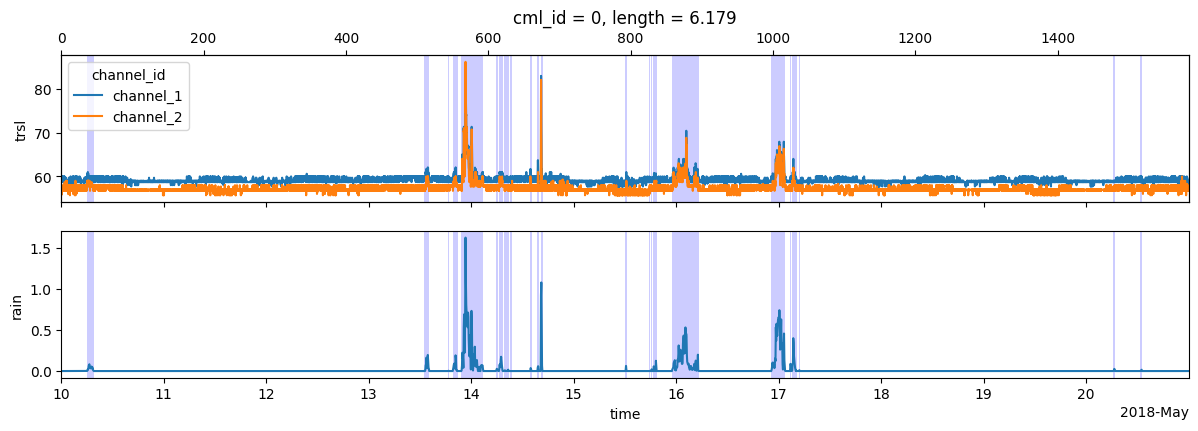

In [61]:
# shaded refernece wet periods from Pycomlink
# set first and last value with zero for correct plotting
ds['ref_wd'][0] = False
ds['ref_wd'][-1] = False

# setup figure
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax2 = axs[0].twiny()
fig.tight_layout()

# plot TRSL
my_cml.trsl.plot.line(x='time', ax=axs[0], label = ('TL'));
# plot Rain rate 
my_ref.rain.plot.line(x='time', ax=axs[1], label = 'TL');

# plot real bool wet/dry with 5min precission
wet_start = np.roll(my_ref.ref_wet_dry, -1) & ~my_ref.ref_wet_dry
wet_end = np.roll(my_ref.ref_wet_dry, 1) & ~my_ref.ref_wet_dry
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[0].axvspan(my_ref.time.values[wet_start_i], my_ref.ref_wet_dry.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
    axs[1].axvspan(my_ref.time.values[wet_start_i], my_ref.ref_wet_dry.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0);



# axes limits source: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html
axs[1].set_xlim(ds.time.values[0,0], ds.time.values[-1,-1])
# in case there are cutof measurements due to sample grouping, we use their amount to align x axes right
ax2.set_xlim(0, n_samples + cutoff)
axs[0].set_xlabel('')
axs[1].set_title("")

#### Standardising
"Subtracting the median of all available data from the preceding 72h from each time step."[2]   

Method: divide all trsl points with the median value for specified channell

In [62]:
# Calculate median and divide trsl for bot channels
#median_tot = ds.trsl.median(axis=(1,2), skipna=True)
#ds['trsl'] = ds.trsl / median_tot

# Standardising to 0-1 fullscale
ds['trsl_st'] = (ds.trsl-ds.trsl.values.mean())  / (ds.trsl.values.max()-ds.trsl.values.mean())


#### Training/Testing data splitting
https://github.com/jpolz/cml_wd_pytorch/blob/main/wd_pytorch/train_cnn.ipynb [2]

In [63]:
# for tensors we need to make sample_num the first dimension
ds['trsl_st'] = ds.trsl_st.transpose('sample_num', 'channel_id', 'timestep')

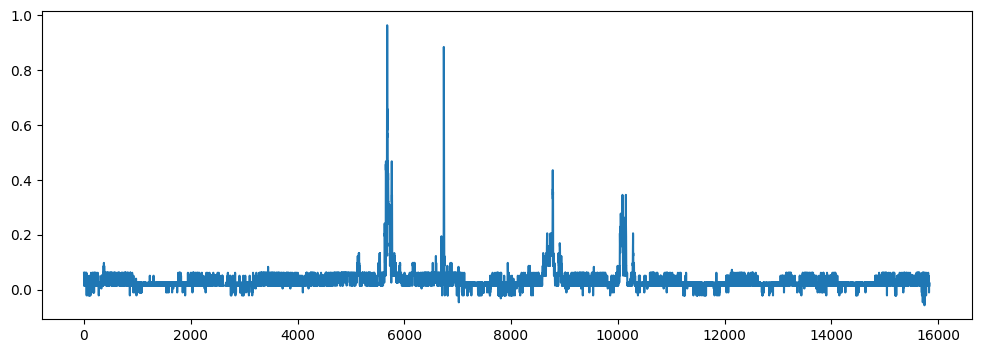

In [64]:
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(12,4))

axs.plot(ds.trsl_st.values[:,0,:].reshape(-1))

In [65]:
batchsize = 20
k_train = 0.8     # fraction of training data

train_size = int(len(ds.sample_num)*k_train/batchsize)* batchsize
train_size

1260

In [66]:
# check frequency of wet and dry ocasions
n_wet = sum(ds.ref_wd.values)
n_dry = sum(~ds.ref_wd.values)

print('Real wet percentage is: ', (n_wet/n_samples*100).round(decimals=2), '%')

Real wet percentage is:  9.47 %


#### Convert to Tensor DataSets

Shuffling data disabled, splitting and turning to arrays

In [67]:
# shuffling samples
#trsl, ref = shuffle(ds.trsl_st.values, ds.ref_wd.values)

# without shuffling
trsl = ds.trsl_st.values
ref = ds.ref_wd.values

train_data = trsl[:train_size]
test_data = trsl[train_size:]
train_ref = ref[:train_size]
test_ref = ref[train_size:]

Storing as tensors [2]

In [68]:
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)

train_ref = torch.Tensor(train_ref)
test_ref = torch.Tensor(test_ref)

Turning into dataset, shuffling

In [69]:
dataset = torch.utils.data.TensorDataset(train_data, train_ref)
testset = torch.utils.data.TensorDataset(test_data, test_ref)

trainloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize, shuffle = False)    # shuffle the training data, once more? True
testloader = torch.utils.data.DataLoader(testset, batch_size = batchsize, shuffle = False)

## Training the CNN

In [70]:
model = cnn.cnn_class()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# try lower training rate and no dropout


In [71]:
epochs = 30    # experimentally max epochs: 30, overfitting around 15
resume = 0     # continue learning at epoch xx 
# Low epochs make cnn output low? around 0.5 max

In [72]:
if resume == 0:
    loss_dict = {}
    loss_dict['train'] = {}
    loss_dict['test'] = {}
    for key in ['train','test']:
        loss_dict[key]['loss'] = []

29

train loss: 0.13821706
test loss: 0.09318565
min test loss: 0.075959265


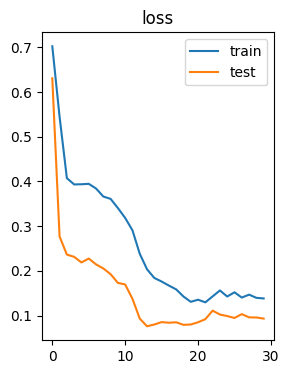

In [73]:
for epoch in range(resume, epochs):
    # training
    cnn_prediction = []
    train_losses = []
    for inputs, targets in tqdm(trainloader):
        optimizer.zero_grad()
        pred = model(inputs)
        pred = nn.Flatten(0,1)(pred)            # transpose column data into row
        # calculating the loss function

        # getting the output
        if epoch == epochs-1: cnn_prediction = cnn_prediction+pred.tolist()
        
        loss = nn.BCELoss()(pred, targets)      # Targets and Imputs size must match
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    loss_dict['train']['loss'].append(np.mean(train_losses))

    
    # testing
    test_losses = []
    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            pred = model(inputs)
            # pred = pred.round()
            pred = nn.Flatten(0,1)(pred)
            
            # getting the output
            if epoch == epochs-1: cnn_prediction = cnn_prediction+pred.tolist()
                
            loss = nn.BCELoss()(pred, targets)
            test_losses.append(loss.detach().numpy())
        loss_dict['test']['loss'].append(np.mean(test_losses))
        
    # printing
    clear_output(wait=True)
    print(epoch)
    print('')
    print('train loss:', np.mean(train_losses))
    print('test loss:', np.mean(test_losses))
    print('min test loss:', np.min(loss_dict['test']['loss']))
    fig, axs = plt.subplots(1,1, figsize=(3,4))
    for key in loss_dict.keys():
        for k, key2 in enumerate(loss_dict[key].keys()):
            axs.plot(loss_dict[key][key2], label=key)
            axs.set_title(key2)
    # axs.set_yscale('log')
    plt.legend()
    plt.show()
    resume = epoch

## Data validation
prediction output, confusion matrix, MCC...
#### Plot the prediction output
#### <span style="color:red">TODO: </span>Add Legends to figures

In [74]:
ds['cnn_out'] = (('sample_num'), np.array(cnn_prediction))
cnn_wd_threshold = 0.5

ds['cnn_wd'] = (('sample_num'), ds.cnn_out.values > cnn_wd_threshold)

In [75]:
# predicted true wet
ds['true_wet'] = ds.cnn_wd & ds.ref_wd 
# cnn false alarm
ds['false_alarm'] = ds.cnn_wd & ~ds.ref_wd
# cnn missed wet
ds['missed_wet'] = ~ds.cnn_wd & ds.ref_wd

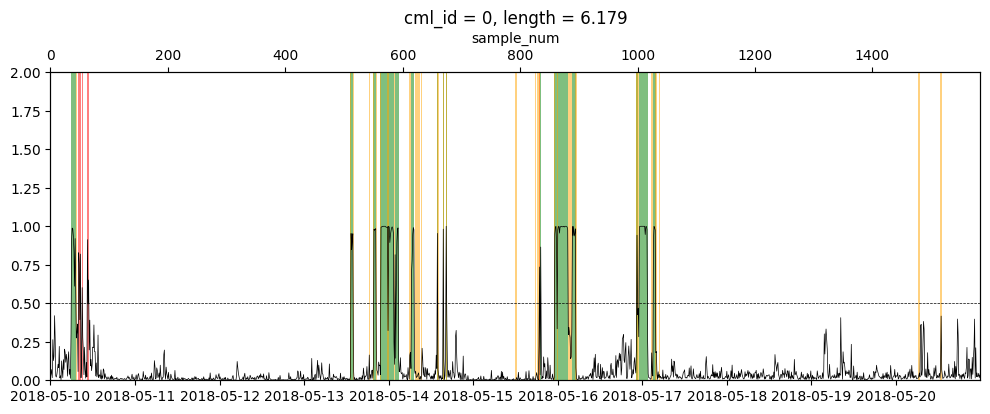

In [76]:
# setup figure
fig, ax1 = plt.subplots(figsize=(12,4), sharex=True)
ax2 = ax1.twiny()

ax1.set_xlim(ds.time.values[0,0], ds.time.values[-1,-1])

ax2.set_xlim(0, n_samples + cutoff)
ax1.set_ylim(0,2);
ax2.set_xlabel('sample number')

# plot cnn prediction
ds.cnn_out.plot.line(x='sample_num', ax=ax2, label = 'TL',color='black', lw=0.5);

#cnn threshold
ax2.axhline(cnn_wd_threshold, color='black', linestyle='--', lw=0.5)

# GREEN: plot true cnn predicted wet/dry areas
# tip from stack ovefrolw: https://stackoverflow.com/questions/44632903/setting-multiple-axvspan-labels-as-one-element-in-legend
wet_start = np.roll(ds.true_wet, -1) & ~ds.true_wet
wet_end = np.roll(ds.true_wet, 1) & ~ds.true_wet
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax2.axvspan(ds.sample_num.values[wet_start_i], ds.sample_num.values[wet_end_i], color='g', alpha=0.5, linewidth=0, label='_'*wet_start_i+'true wet') 

# RED: plot false alarms
wet_start = np.roll(ds.false_alarm, -1) & ~ds.false_alarm
wet_end = np.roll(ds.false_alarm, 1) & ~ds.false_alarm
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax2.axvspan(ds.sample_num.values[wet_start_i], ds.sample_num.values[wet_end_i], color='r', alpha=0.5, linewidth=0, label='_'*wet_start_i+'false alarm') 
    
# ORANGE: plot missed wet 
wet_start = np.roll(ds.missed_wet, -1) & ~ds.missed_wet
wet_end = np.roll(ds.missed_wet, 1) & ~ds.missed_wet
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax2.axvspan(ds.sample_num.values[wet_start_i], ds.sample_num.values[wet_end_i], color='orange', alpha=0.5, linewidth=0, label='_'*wet_start_i+'missed wet')

#ax2.legend(bbox_to_anchor=(0.73,-0.35), ncol=3)

#### ROC curve

source: [2], https://github.com/jpolz/cnn_cml_wet-dry_example/blob/master/CNN_for_CML_example_nb.ipynb  

In [77]:
def roc_curve(y_pred, y_true, tr_start, tr_end):
    '''
    Compute the ROC curve for the CNN. The minimum threshold is tr_start and the maximum threshold is tr_end.
    '''
    roc = []
    for i in range(tr_start*1000,1+tr_end*1000,1):
        t = i/1000
        y_predicted=np.ravel(y_pred>t)  
        true_pos = np.sum(np.logical_and(y_true==1, y_predicted==1))
        true_neg = np.sum(np.logical_and(y_true==0, y_predicted==0))
        false_pos = np.sum(np.logical_and(y_true==0, y_predicted==1))
        false_neg = np.sum(np.logical_and(y_true==1, y_predicted==0))
        cond_neg = true_neg+false_pos
        cond_pos = true_pos+false_neg
        roc.append([true_pos/cond_pos,
                    false_pos/cond_neg])
    roc.append([0,0])
    
    return np.array(roc)

def roc_surface(roc):
    '''
    Compute the Area under a ROC curve.
    '''
    k = len(roc)
    surf=0
    for i in range(k-1):
        surf= surf+(np.abs(roc[i,1]-roc[i+1,1]))*0.5*(roc[i+1,0]+roc[i,0])
    
    return surf

In [78]:
# ROC curve
roc = roc_curve(ds.cnn_out, ds.ref_wd, 0, 1)


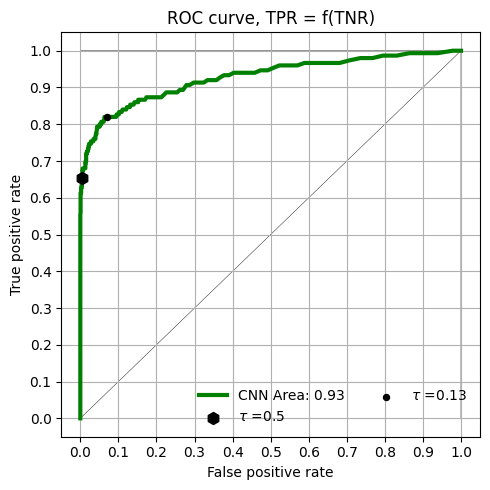

In [79]:
plt.figure(figsize=(5,5))
plt.plot(roc[:,1],roc[:,0], color='green', label='CNN Area: '+str(np.round(roc_surface(roc), decimals=2)), zorder=2, lw=3)

# plot point of cnn threshold for optimalisation
plt.scatter(roc[int(cnn_wd_threshold*1000),1],roc[int(cnn_wd_threshold*1000),0], color='black', marker='h', s=75, label='$\\tau$ ='+str(cnn_wd_threshold), zorder=3)
thr = 0.13
plt.scatter(roc[int(thr*1000),1],roc[int(thr*1000),0], color='black', marker='.', s=75, label='$\\tau$ ='+str(thr), zorder=3)

plt.plot([0,0,1,0,1,1],[0,1,1,0,0,1], 'k-', linewidth=0.3, zorder=1)
plt.title('ROC curve, TPR = f(TNR)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right', ncol=2, frameon=False)
plt.grid()
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xticks(np.arange(0, 1.01, 0.1))
plt.tight_layout()
plt.show()

#### MCC, ACC, confusion matrix
source: [2], https://github.com/jpolz/cnn_cml_wet-dry_example/blob/master/CNN_for_CML_example_nb.ipynb

In [80]:
print('CNN scores')

# confusion matrix 
cm = skl.confusion_matrix(ds.ref_wd, ds.cnn_wd, labels=[0,1], normalize='true').round(decimals=2)
print('normalized confusion matrix:\n',cm)

print('confusion matrix:\n',skl.confusion_matrix(ds.ref_wd, ds.cnn_wd).round(decimals=2))
print('TNR:', cm[0,0])
print('TPR:', cm[1,1])

# Matthews Correlation Coeficient
mcc = skl.matthews_corrcoef(ds.ref_wd, ds.cnn_wd).round(decimals=2)
print('MCC:', mcc)

# 
acc = np.round(skl.accuracy_score(ds.ref_wd, ds.cnn_wd), decimals=2)
print('ACC:', acc)

f1 = skl.f1_score(ds.ref_wd, ds.cnn_wd).round(decimals=2)
print('F1:', f1)

# ROC curve surface
a = roc_surface(roc).round(decimals=2)
print('ROC surface A:', a)

CNN scores
normalized confusion matrix:
 [[1.   0.  ]
 [0.35 0.65]]
confusion matrix:
 [[1427    7]
 [  52   98]]
TNR: 1.0
TPR: 0.65
MCC: 0.76
ACC: 0.96
F1: 0.77
ROC surface A: 0.93


C:\Users\lukas\AppData\Local\Temp\ipykernel_11504\1832566141.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''] + labels)
C:\Users\lukas\AppData\Local\Temp\ipykernel_11504\1832566141.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([''] + labels)


Text(0.5, 1.0, 'CNN')

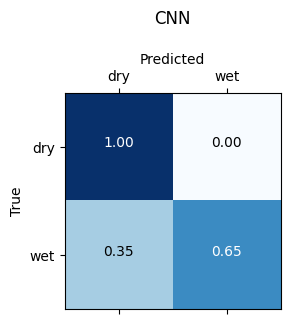

In [81]:
import itertools

# plot the confusion matrix
labels = ['dry', 'wet']

fig, ax1 = plt.subplots(figsize=(3,3), sharex=True)
#ax1 = fig.add_subplot(131)

cax = ax1.matshow(cm, cmap=plt.cm.Blues)
ax1.set_xticklabels([''] + labels)
ax1.set_yticklabels([''] + labels)
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted')
plt.ylabel('True')
ax1.xaxis.set_label_position('top') 
plt.tight_layout()
plt.title('CNN', pad=50)

## Wet Antenna Attenuation
For CNN predicted wet/dry periods.  
Using modules imported from Pycomlink

#### <span style="color:red">TODO: </span>Reshape dataset back to time domain
<span style="color:red">Assuming, each reference RADOLAN rain sample taken in time TT is measurement from <TT; TT + 5min> period. </span> This assumption may itroduce up to 5min time shift between reference and CML data (TT measurement contains rather value from <TT-5min; TT>), but doesn't introduce any invasive change to the original data.  
In future RADOLAN ref values may be shifted -5 minutes.

In [82]:
# Reshape dataset back to time domain
trsl_waa = ds['trsl'].values.reshape(2,-1)
cnn_waa = np.repeat(ds['cnn_wd'].values.reshape(-1),10)   # cnn_wd output upsampled to 1min by repeating the values 
time_waa = ds['time'].values.reshape(-1)                  # to be dimension again

In [83]:
# Create a new xarray Dataset in time domain
# cnn_wd upsampled 10 times
ds_waa = xr.Dataset({
    'trsl': (('channel_id', 'time'), trsl_waa),
    'cnn_wd': (('time'), cnn_waa)
}, coords={'channel_id': np.arange(2),
           'time': time_waa,
           'cml_id': cml_id,
           'length': length,                                  #single value is never a dimension
           'frequency': (('channel_id'), frequency),          # this way coordinate will not become a dimension
           'polarization': (('channel_id'), polarization)
           })

#### CML baseline for CNN predicted Wet signal calculated with Pycomlink modul

In [84]:
import pycomlink as pycml

ds_waa['baseline'] = pycml.processing.baseline.baseline_constant(trsl=ds_waa.trsl, wet=ds_waa.cnn_wd, n_average_last_dry=5)

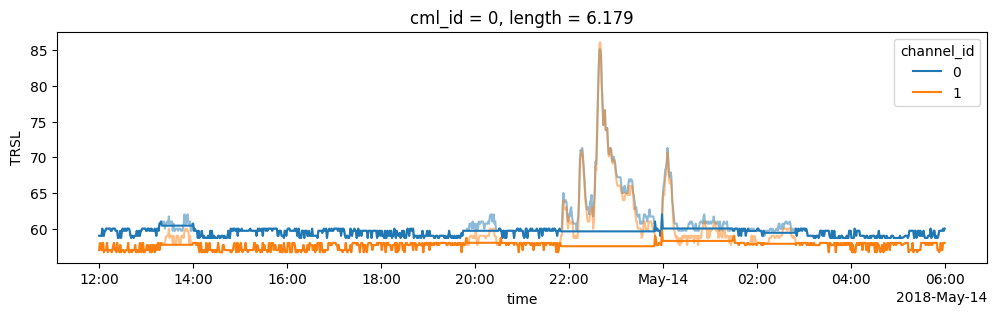

In [85]:
fig, ax = plt.subplots(figsize=(12,3))

ds_waa.trsl.sel(time=slice('2018-05-13T12:00', '2018-05-14T06:00')).plot.line(x='time', alpha=0.5)
plt.gca().set_prop_cycle(None)  # reuse plot colors
ds_waa.baseline.sel(time=slice('2018-05-13T12:00', '2018-05-14T06:00')).plot.line(x='time');
plt.ylabel('TRSL');

#### Wet antenna attenuation estimation
from Pyomlink using Schleiss 2013. mathematical model

In [86]:
ds_waa['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=ds_waa.trsl, 
    baseline=ds_waa.baseline, 
    wet=ds_waa.cnn_wd, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

In [87]:
ds_waa['baseline_waa_c'] = ds_waa.baseline + ds_waa.waa
ds_waa['rain_att'] = ds_waa.trsl - ds_waa.baseline_waa_c
ds_waa['rain_att'].values[ds_waa.rain_att < 0] = 0

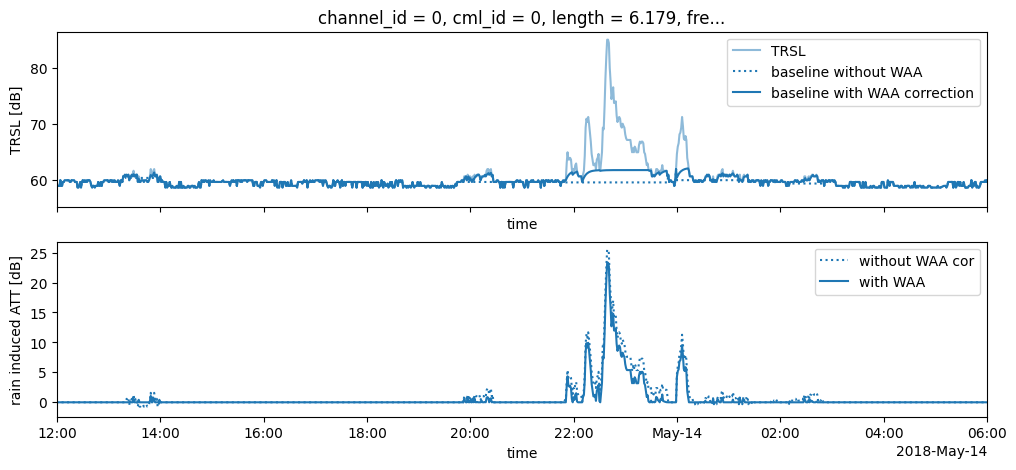

In [88]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

plt.sca(axs[0])
ds_waa.isel(channel_id=0).trsl.plot.line(x='time', alpha=0.5, label='TRSL')
plt.gca().set_prop_cycle(None)
ds_waa.isel(channel_id=0).baseline.plot.line(x='time', linestyle=':', label='baseline without WAA');
plt.gca().set_prop_cycle(None)
ds_waa.baseline_waa_c.isel(channel_id=0).plot.line(x='time', label='baseline with WAA correction');
plt.ylabel('TRSL [dB]')
axs[0].legend()


plt.sca(axs[1])
(ds_waa.trsl-ds_waa.baseline).isel(channel_id=0).plot.line(x='time', linestyle=':', label='without WAA cor');
plt.gca().set_prop_cycle(None)
ds_waa.rain_att.isel(channel_id=0).plot.line(x='time', label='with WAA');
plt.ylabel('rain induced ATT [dB]');
axs[1].set_title('');
axs[1].legend()

axs[1].set_xlim(pd.to_datetime('2018-05-13T12:00'), pd.to_datetime('2018-05-14T06:00'));

#### Rain rate estimation using kR relation

In [89]:
ds_waa['r_est'] = pycml.processing.k_R_relation.calc_R_from_A(A=ds_waa.rain_att, 
                                                              L_km=float(ds_waa.length), 
                                                              f_GHz=ds_waa.frequency/1e9, 
                                                              pol=ds_waa.polarization)

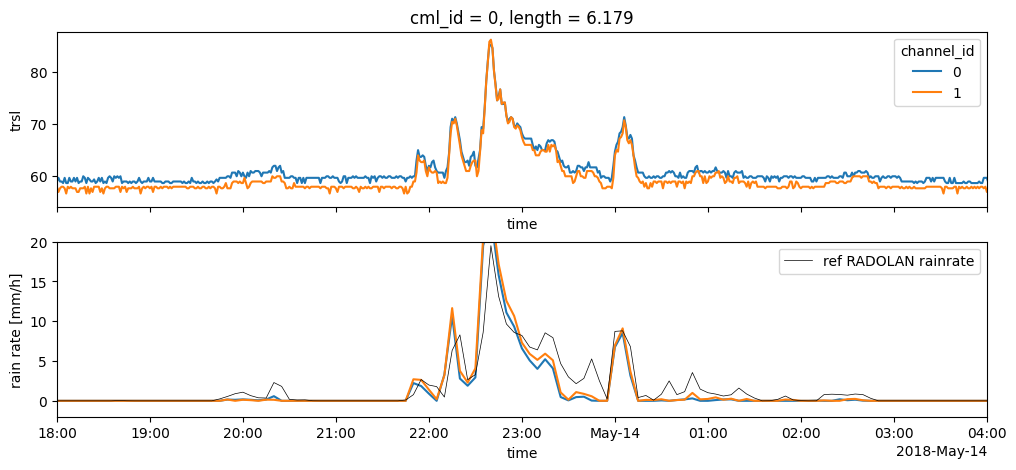

In [98]:
# note: 
#     Reference 1h rainfall rate sampled to 5 min has to be converted to 5min rain rate ... multiplied by 60/5 min
#     CML rain rate will be resampled to 5 min 


fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)
ds_waa.trsl.plot.line(x='time', ax=axs[0])
plt.ylabel('trsl [dB]');

ds_waa.r_est.resample(time='5min').mean().plot.line(x='time', ax=axs[1])
(my_ref.rain*12).plot.line(x='time', ax=axs[1], color='black', lw=0.5, label='ref RADOLAN rainrate')
plt.ylabel('rain rate [mm/h]');

axs[1].set_xlim(pd.to_datetime('2018-05-13T18:00'), pd.to_datetime('2018-05-14T04:00'));
axs[1].set_title('');
axs[1].legend();
axs[1].set_ylim(-2,20);

original validation [2]:

In [91]:
for inputs, targets in tqdm(trainloader):
    print(nn.Flatten(0,1)(model(inputs)))
    print(targets)
    break

  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

tensor([0.0115, 0.0076, 0.0205, 0.0760, 0.1736, 0.0616, 0.0696, 0.4212, 0.2231,
        0.0268, 0.0191, 0.0231, 0.0767, 0.0910, 0.0450, 0.2563, 0.0206, 0.0926,
        0.0400, 0.0685], grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [92]:
### accuracy score, confusion matrix and Matthews correlation coefficient (MCC)
def eval_model(test_dataloader, model):
    predictions, actuals = list(), list()
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader):
            pred = model(inputs)
            pred = pred.detach().numpy()
            actual = targets.numpy()
            actual = actual.reshape((len(actual), 1))
            pred = pred.round()
    
            predictions.append(pred)
            actuals.append(actual)
    predictions, actuals = np.ravel(np.vstack(predictions)), np.ravel(np.vstack(actuals))
    acc = skl.accuracy_score(actuals, predictions)
    conf_mat = skl.confusion_matrix(actual, pred, labels=[0,1], normalize='all')
    matt_cor = skl.matthews_corrcoef(actual, pred)
    return acc, conf_mat, matt_cor, predictions

In [93]:
eval_model(testloader, model)

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 154.63it/s]
D:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


(0.9845679012345679,
 array([[1., 0.],
        [0., 0.]]),
 0.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

### rolling standard deviation classification for reference

In [94]:
threshold = 0.8

roll_std_dev = my_cml.trsl.rolling(time=60, center=True).std()
my_cml['rsd_wet'] = my_cml.trsl.rolling(time=60, center=True).std() > threshold

In [95]:
my_cml

<xarray.Dataset> Size: 1MB
Dimensions:       (time: 15840, channel_id: 2)
Coordinates:
  * time          (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T23:59:00
  * channel_id    (channel_id) <U9 72B 'channel_1' 'channel_2'
    cml_id        <U3 12B '0'
    length        float64 8B 6.179
    frequency     (channel_id) float64 16B 2.491e+10 2.592e+10
    polarization  (channel_id) <U1 8B 'V' 'V'
Data variables:
    rsl           (channel_id, time) float64 253kB -47.0 -47.0 ... -46.7 -47.0
    tsl           (channel_id, time) float64 253kB 13.0 12.0 12.0 ... 10.0 10.0
    trsl          (channel_id, time) float64 253kB 60.0 59.0 58.7 ... 56.7 57.0
    rain          (time) float64 127kB 0.0 nan nan nan nan ... nan nan nan nan
    rsd_wet       (channel_id, time) bool 32kB False False False ... False False

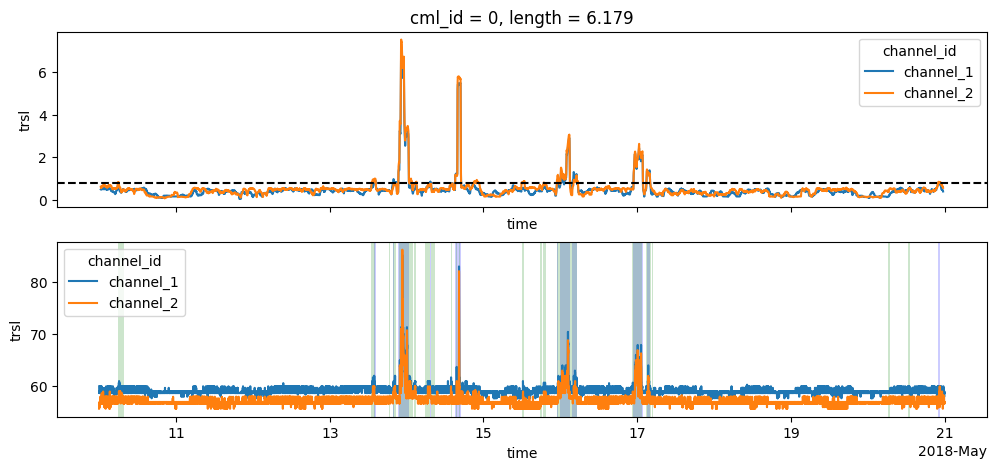

In [96]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

roll_std_dev.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--')

my_cml.trsl.plot.line(x='time', ax=axs[1]);

# Get start and end of dry event
wet_start = np.roll(my_cml.rsd_wet, -1) & ~my_cml.rsd_wet
wet_end = np.roll(my_cml.rsd_wet, 1) & ~my_cml.rsd_wet

# Plot shaded area for each RSD predicted wet event
for wet_start_i, wet_end_i in zip(
    wet_start.isel(channel_id=0).values.nonzero()[0],
    wet_end.isel(channel_id=0).values.nonzero()[0],
):
    axs[1].axvspan(my_cml.time.values[wet_start_i], my_cml.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0)

axs[1].set_title('');

# plot real bool wet/dry with 5min precission
wet_start = np.roll(my_ref.ref_wet_dry, -1) & ~my_ref.ref_wet_dry
wet_end = np.roll(my_ref.ref_wet_dry, 1) & ~my_ref.ref_wet_dry
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(my_ref.time.values[wet_start_i], my_ref.ref_wet_dry.time.values[wet_end_i], color='g', alpha=0.2, linewidth=0) # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html